# Final Capstone Project

### Business Problem:

   Using data on the venues present in different neighborhoods of Atlanta, GA combined with average rent of each neighborhood. We will train a linear regression model to predict rent prices of a neighborhood. This problem will require the use of Foursquare API to get local venues as well as data about rent and neighborhood location which will be aquired through various sources. This report should interest developers and landlords wondering where to build or how much to charge for rent as well as renters who are looking for a place to rent and are interested in how much is fair rent. Finally this report will also interest city officials who will be able to gain insight on certian venues effects on neighborhood rent.

### Backgroud:

   The neighborhoods that comprise the city of Atlanta are rich with history. Atlanta was the home of many civil rights leaders such as John Lewis, Ralph David Abernathy, Dr. Martin Luther King Jr, and many more. The neighborhoods they resided in are decorated with tributes to their historic neighbors. However the neighborhoods of Atlanta have also been shaped by its less glamourous history. During the American Civil War Atlanta was a crucial stronghold of the confederacy due to the multiple railroads that intersected within the city making the city crucial for sending supplies to confederate troops throughout the South East. In 1864 during the Union Army's "March to the Sea" led by General William Sherman the city of Atlanta was burnt down (with some help from the retreating confederates) and it's residents displaced. After the Civil War ended in 1865, Atlanta began its rebuilding process which was accelerated due to the cities extensive railroad network. This rebuilding led to a boom in the city's population and the city of Atlanta was made the capital city of Georgia soon after. The city experienced significant growth through the late 1800's and early 1900's however racial tensions and Jim Crow laws would make a lasting mark on the city. In 1906 the Atlanta Race Riots forced black residents out of the booming Downtown Atlanta into the Sweet Auburn neighborhood which remains a predominantly black neighborhood to this day. Further red lining and segregation led to some very noticable differences throughout the neighborhoods such as roads being renamed as they pass through historically "Black" or "White" neighborhoods (i.e. Boulevard becoming Monroe and Moreland becoming Braircliff). After sustained growth through the 20th century including the construction of the world's busiest airport in south Atlanta, several interstates that pass through the city, establishing of universities within the city such as Georgia Tech, Morehouse, Emory University. The huge growth of Atlanta throughout the 20th century was capstoned with the 1996 Summer Olympics being hosted in the city. Current day Atlanta is composed of an incredibly diverse, well-educated, and young population which has grown over 24% in the last decade making it one of the fastest growing cities in the U.S. 

### Data

   The Data that will be used to approach this problem will come from [RentCafe](https://www.rentcafe.com/average-rent-market-trends/us/ga/atlanta/) for the average rent per neighborhood, Geopy for the latitude and longitude data, and finally the Foursquare API to get venue data.  

#### Constructing Average Rent Dataframe

In [2]:
import pandas as pd
import numpy as np
from selenium import webdriver
from time import sleep
import requests
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import seaborn as sns

In [7]:
# creating lists
neighborhoods = []
rents = []

# initializing chrome driver and opening wikipedia page
browser = webdriver.Chrome()
browser.get('https://www.rentcafe.com/average-rent-market-trends/us/ga/atlanta/')
sleep(5)

# View all table cells
cookie = browser.find_element_by_xpath("//*[@id='cookieinfopolicy']/div")
cookie.click()
veiw_all = browser.find_element_by_xpath("//*[@id='MarketTrendsAverageRentTableFullView']")
veiw_all.click()

# locating table columns by xpath
neighbor = browser.find_elements_by_xpath("//*[@id='MarketTrendsAverageRentTable']//*[@class='current-row']/th")
rent = browser.find_elements_by_xpath("//*[@id='MarketTrendsAverageRentTable']//*[@class='current-row']/td")
print(len(neighbor))
print(len(rent))

# copying data of first column to neighborhoods list
for i in neighbor:
    neighborhoods.append(i.text)
    
# copying data of second column to rents list
for i in rent:
    rents.append(i.text)

browser.close()

# combining lists created above
lst = zip(neighborhoods, rents)

# creating dataframe containing list data
df = pd.DataFrame(lst, columns = ["Neighborhood", "Avg. Rent"])
df.loc[:,"Avg. Rent"] = df["Avg. Rent"].replace('[\$,]', '', regex=True).astype(int)
df

632
632


,Neighborhood,Avg. Rent
0,Ansley Park,2046
1,Ardmore,2046
2,Brookwood Hills,2046
3,Collier Hills North,2046
4,Colonial,2046
...,...,...
627,Pomona Park,950
628,Regency Point,950
629,Southwest Atlanta,950
630,Sunridge Construction,950


#### Getting Latitude and Longitude of each neighborhood

In [54]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="Atlanta_rent")

lat = []
long = []

# Use geopy to get Lat, Long for each neighborhood
for i in neighborhoods:
    try:
        location = geolocator.geocode(i + ", Atlanta, GA")
        lat.append(location.latitude)
        long.append(location.longitude)
    except AttributeError:
        # if no 
        lat.append(np.nan)
        long.append(np.nan)
        pass

lst = zip(neighborhoods, lat, long)

# creating dataframe containing list data
lat_long_atlanta = pd.DataFrame(lst, columns = ["Neighborhood", "Latitude", "Longitude"])
lat_long_atlanta

,Neighborhood,Latitude,Longitude
0,Ansley Park,33.794550,-84.376315
1,Ardmore,33.806282,-84.400028
2,Brookwood Hills,33.807883,-84.390205
3,Collier Hills North,NaN,NaN
4,Colonial,33.814125,-84.397469
...,...,...,...
627,Pomona Park,NaN,NaN
628,Regency Point,-7.745800,110.357041
629,Southwest Atlanta,45.004757,-84.151970
630,Sunridge Construction,NaN,NaN


#### Combine and Clean data

In [56]:
new_df = pd.merge(df, lat_long_atlanta, on="Neighborhood", how="inner")
new_df

,Neighborhood,Avg. Rent,Latitude,Longitude
0,Ansley Park,2046,33.794550,-84.376315
1,Ardmore,2046,33.806282,-84.400028
2,Brookwood Hills,2046,33.807883,-84.390205
3,Collier Hills North,2046,NaN,NaN
4,Colonial,2046,33.814125,-84.397469
...,...,...,...,...
637,Pomona Park,950,NaN,NaN
638,Regency Point,950,-7.745800,110.357041
639,Southwest Atlanta,950,45.004757,-84.151970
640,Sunridge Construction,950,NaN,NaN


After combining the data sets I need to deal with missing values. With the code below I can see that Latitude and Longitude are missing 452 out of 642 values

In [57]:
len(new_df["Neighborhood"].unique())
missing_data = new_df.isnull()

for column in missing_data.columns.values.tolist():
    print(column)
    print (missing_data[column].value_counts())
    print("")   

Neighborhood
False    642
Name: Neighborhood, dtype: int64

Avg. Rent
False    642
Name: Avg. Rent, dtype: int64

Latitude
True     455
False    187
Name: Latitude, dtype: int64

Longitude
True     455
False    187
Name: Longitude, dtype: int64



In [58]:
# drop rows with NaN in "Latitude" column
new_df.dropna(subset=["Latitude"], axis=0, inplace=True)

# drop rows with NaN in "Longitude" column
new_df.dropna(subset=["Longitude"], axis=0, inplace=True)

# reset index
new_df.reset_index(drop=True, inplace=True)
new_df

,Neighborhood,Avg. Rent,Latitude,Longitude
0,Ansley Park,2046,33.794550,-84.376315
1,Ardmore,2046,33.806282,-84.400028
2,Brookwood Hills,2046,33.807883,-84.390205
3,Colonial,2046,33.814125,-84.397469
4,Piedmont Park,2046,33.789048,-84.371886
...,...,...,...,...
182,Cascade Heights,950,33.722330,-84.463263
183,Cascade Road,950,33.720639,-84.469215
184,Ivan Hill,950,33.764858,-84.389215
185,Regency Point,950,-7.745800,110.357041


Now that I have removed all the missing values, I am looking for incorrect location values by finding outliers in terms of distance from Atlanta

In [59]:
atlanta_lat = 33.753746
atlanta_long = -84.386330

# Calculating Distance from the center of Atlanta
new_df["Distance From ATL"] = ((new_df["Latitude"]-atlanta_lat)**2 + (new_df["Longitude"]-atlanta_long)**2)**0.5
dirty_df = new_df
dirty_df

,Neighborhood,Avg. Rent,Latitude,Longitude,Distance From ATL
0,Ansley Park,2046,33.794550,-84.376315,0.042015
1,Ardmore,2046,33.806282,-84.400028,0.054293
2,Brookwood Hills,2046,33.807883,-84.390205,0.054275
3,Colonial,2046,33.814125,-84.397469,0.061398
4,Piedmont Park,2046,33.789048,-84.371886,0.038142
...,...,...,...,...,...
182,Cascade Heights,950,33.722330,-84.463263,0.083100
183,Cascade Road,950,33.720639,-84.469215,0.089252
184,Ivan Hill,950,33.764858,-84.389215,0.011480
185,Regency Point,950,-7.745800,110.357041,199.116029


### Visualizing Raw Distance for Atlanta data

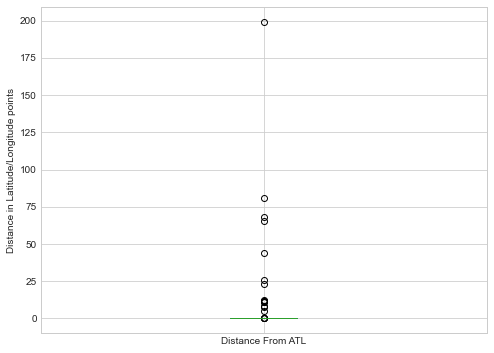

In [60]:
dirty_df["Distance From ATL"].plot(kind='box', figsize=(8, 6))
plt.ylabel("Distance in Latitude/Longitude points")
plt.show()

The Graph above shows many outliers in our Distance From Atlanta column. This tells us that much of the location data is incorrect and/or not relevent to our analysis of the city of atlanta.

In [61]:
new_df["Distance From ATL"].describe()

count    187.000000
mean       3.208554
std       17.518176
min        0.002349
25%        0.048566
50%        0.071846
75%        0.128389
max      199.116029
Name: Distance From ATL, dtype: float64

Removing outlier distances from data set. This will result in a data set in which every neighborhood is within a moderate distance of the center of Atlanta

In [95]:
# Defining an outlier as anything greater than 1.5 * 75th percentile
outlier = 0.136748 * 1.5

indexes = new_df[new_df["Distance From ATL"] > outlier].index
new_df.drop(indexes, inplace=True)
clean_df = new_df.drop_duplicates()
clean_df.rename(columns={"Avg. Rent":"Rent"}, inplace=True)
clean_df.reset_index(drop=True)

,Neighborhood,Rent,Latitude,Longitude,Distance From ATL
0,Ansley Park,2046,33.794550,-84.376315,0.042015
1,Ardmore,2046,33.806282,-84.400028,0.054293
2,Brookwood Hills,2046,33.807883,-84.390205,0.054275
3,Colonial,2046,33.814125,-84.397469,0.061398
4,Piedmont Park,2046,33.789048,-84.371886,0.038142
...,...,...,...,...,...
151,Adams Park,950,33.712052,-84.456873,0.081943
152,Campbellton Road,950,33.693159,-84.517901,0.144851
153,Cascade Heights,950,33.722330,-84.463263,0.083100
154,Cascade Road,950,33.720639,-84.469215,0.089252


### Visualizing Clean Distance From Atlanta data for Neighborhoods

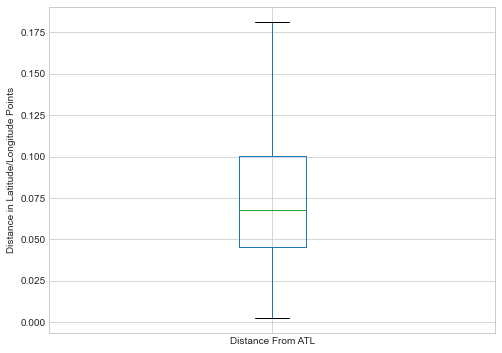

In [63]:
clean_df["Distance From ATL"].plot(kind='box', figsize=(8, 6))
plt.ylabel("Distance in Latitude/Longitude Points")
plt.show()

### Visualizing Average Rent Per Neighborhood

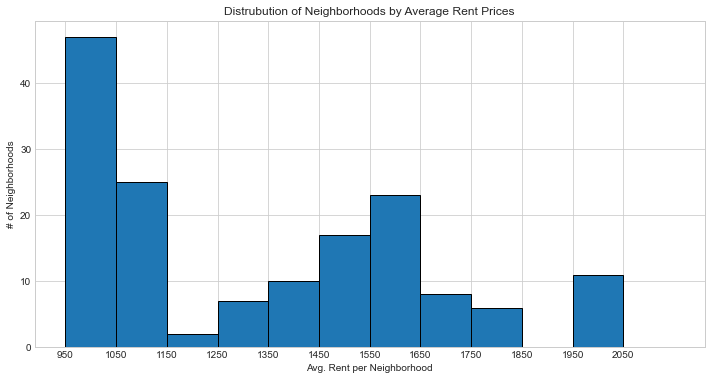

In [96]:
plt.figure(figsize=(12,6))
plt.style.use('seaborn-whitegrid')
plt.hist(clean_df["Rent"], bins=[950,1050,1150,1250,1350,1450,1550, 1650,1750,1850,1950,2050, 2150], edgecolor='#000000')
plt.xticks([950,1050,1150,1250,1350,1450,1550,1650,1750,1850,1950,2050])
plt.xlabel('Avg. Rent per Neighborhood')
plt.ylabel('# of Neighborhoods')
plt.title("Distrubution of Neighborhoods by Average Rent Prices")
plt.show()

By visualizing the dataframe we have left we can see that our most common rent price for a neighborhood is between `$950 and $1050` and we can also see that there are no neighborhoods in our dataset with average rent values between `$1850 and $1950`. 

### Mapping Neighborhoods in Atlanta

In [331]:
import folium
atl_map = folium.Map(location=[atlanta_lat, atlanta_long], zoom_start=12)

neighborhood_markers = folium.map.FeatureGroup()

# loop through the neighborhoods and add each to feature group
for lat, lng, rent, neighborhood in zip(clean_df.Latitude, clean_df.Longitude, clean_df.Rent, clean_df.Neighborhood):
    neighborhood_markers.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            # size of 
            radius=10*(rent/clean_df.Rent.mean()),
            fill=True,
            fill_color='blue',
            fill_opacity=0.6,
            popup=neighborhood
        )
    )
    

The map below shows the concentration of neighborhoods with the size of each marker representing average rent. Larger markers represent greater values of average rent 

In [332]:
# add neighborhoods to map
atl_map.add_child(neighborhood_markers)

### Binning Neighborhoods

In [330]:
bin_labels = [1, 2, 3, 4]
clean_df["Bin"] = pd.qcut(clean_df["Rent"], q=4, labels=bin_labels)
clean_df["Color"] = pd.qcut(clean_df["Rent"], q=4, labels=["Red", "Green", "Blue", "Yellow"])
clean_df.head(40)

<ipython-input-330-0eae90b6153f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df["Bin"] = pd.qcut(clean_df["Rent"], q=4, labels=bin_labels)
<ipython-input-330-0eae90b6153f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df["Color"] = pd.qcut(clean_df["Rent"], q=4, labels=["Red", "Green", "Blue", "Yellow"])


,Neighborhood,Rent,Latitude,Longitude,Distance From ATL,Bin,Color
0,Ansley Park,2046,33.794550,-84.376315,0.042015,4,Yellow
1,Ardmore,2046,33.806282,-84.400028,0.054293,4,Yellow
2,Brookwood Hills,2046,33.807883,-84.390205,0.054275,4,Yellow
3,Colonial,2046,33.814125,-84.397469,0.061398,4,Yellow
4,Piedmont Park,2046,33.789048,-84.371886,0.038142,4,Yellow
5,Lenox,2011,33.845393,-84.358129,0.095888,4,Yellow
6,Atlantic Station,1987,33.790755,-84.398445,0.038941,4,Yellow
7,Buckhead Forest,1966,33.839814,-84.379559,0.086334,4,Yellow
8,Buckhead Village,1966,33.839814,-84.379559,0.086334,4,Yellow
9,Peachtree Hills,1966,33.815058,-84.391638,0.061541,4,Yellow


In [175]:
clean_df["Bin"].value_counts()

1    46
3    45
2    33
4    32
Name: Bin, dtype: int64

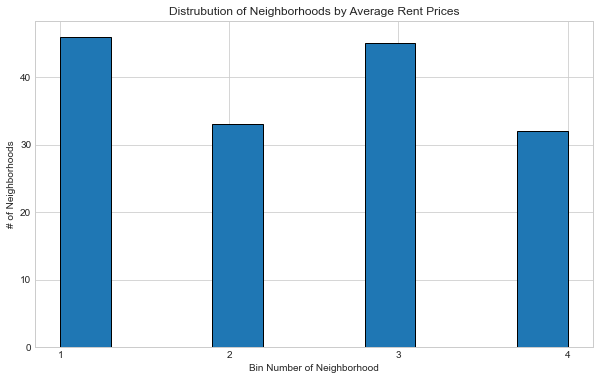

In [186]:
plt.figure(figsize=(10,6))
plt.style.use('seaborn-whitegrid')
plt.hist(clean_df["Bin"],edgecolor='#000000')
plt.xticks([1,2,3,4])
plt.xlabel('Bin Number of Neighborhood')
plt.ylabel('# of Neighborhoods')
plt.title("Distrubution of Neighborhoods by Average Rent Prices")
plt.show()

In [336]:
bin_map = folium.Map(location=[atlanta_lat, atlanta_long], zoom_start=12)

neighborhood_markers = folium.map.FeatureGroup()

# loop through the neighborhoods and add each to feature group
for lat, lng, rent, neighborhood, color in zip(clean_df.Latitude, clean_df.Longitude, clean_df.Rent, clean_df.Neighborhood, clean_df.Color):
    neighborhood_markers.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            # size of 
            radius=5,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.6,
            popup=neighborhood
        )
    )

# add neighborhoods to map
bin_map.add_child(neighborhood_markers)

In the Map above, Neighborhoods binned into the most expensive group are in Yellow, the second most expensive are in Blue, the third most expensive in Green and finally the least expensive neighborhoods in Red

### Find Venue Information per Neighborhood

In [187]:
# @hidden cell
CLIENT_ID = 'RD3GK2KL021H3ZNCPR1R0XA3FP3MIC1KYTKBF3NTNO43NL0X' # your Foursquare ID
CLIENT_SECRET = 'QD44DA4ZVUNOP3LXU0EBWBEMWMPZVGSWZAAVVZVWFAUDLJ3Q' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

In [194]:
def getNearbyVenues(names, latitudes, longitudes, rents, bins, radius=500):
    
    venues_list=[]
    for name, lat, lng, rent, bin_num in zip(names, latitudes, longitudes, rents, bins):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng,
            rent,
            bin_num,
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude',
                  'Neighborhood Rent',
                  'Neighborhood Bin',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [195]:
# gets 100 nearby venues in each neighborhood
atlanta_venues = getNearbyVenues(names=new_df['Neighborhood'],
                                   latitudes= clean_df['Latitude'],
                                   longitudes=clean_df['Longitude'],
                                   rents=clean_df['Rent'],
                                   bins=clean_df["Bin"]
                                  )

Ansley Park
Ardmore
Brookwood Hills
Colonial
Piedmont Park
Lenox
Atlantic Station
Buckhead Forest
Buckhead Village
Peachtree Hills
Midtown Atlanta
Atlanta Memorial Park
Brookwood
Brookwood
Brookwood
Brookwood
Loring Heights
Atkins Park
Virginia Highland
Virginia Park Townhomes
Downtown Atlanta
Springlake
Virgilee Park
Candler Park
Inman Park
Lake Claire
Little Five Points
Lullwater
Oakland
Sweet Auburn
Castleberry Hill
Brandon
Castlewood
Margaret Mitchell
Paces
Bellwood Quarry
Bolton
Carey Park
Collier Heights
Collier Hills
Dupont Commons
Hills Park
Ridgewood Heights
Riverside
Riverside
Riverside
Riverside
Rockdale
Underwood Hills
Westover Plantation
Wildwood
Georgia Tech
Edgewood
Cabbagetown
Dunwoody Springs
Foxcroft
Glenview
Hammond Hills
Armour
Lindbergh
Reynoldstown
Bankhead
Center Hill
Grove Park
Stonewall
Woodland Hills
Woodland Hills
Woodland Hills
Woodland Hills
Benteen Park
Grant Park
Mechanicsville
Summerhill
East Atlanta
Ormewood Park
Chastain
Northland Ridge
The Glenridge
E

In [196]:
atlanta_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Neighborhood Rent,Neighborhood Bin,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Ansley Park,33.794550,-84.376315,2046,4,Piedmont Atlanta BeltLine Sort-of-Urban Dare,33.792436,-84.373845,Trail
1,Ansley Park,33.794550,-84.376315,2046,4,Cascades Garden,33.791002,-84.373586,Garden
2,Ansley Park,33.794550,-84.376315,2046,4,Eclectic Bistro & Bar,33.793401,-84.372352,Bistro
3,Ansley Park,33.794550,-84.376315,2046,4,Boy Next Door,33.794011,-84.371972,Men's Store
4,Ansley Park,33.794550,-84.376315,2046,4,Ansley Park (The Dell),33.794110,-84.376765,Park
...,...,...,...,...,...,...,...,...,...
2202,Parkside,33.764858,-84.389215,950,1,Mayor's Park,33.764581,-84.385398,Park
2203,Parkside,33.764858,-84.389215,950,1,Caribou Coffee,33.762592,-84.385392,Coffee Shop
2204,Parkside,33.764858,-84.389215,950,1,Starbucks,33.761693,-84.385642,Coffee Shop
2205,Parkside,33.764858,-84.389215,950,1,Dunkin',33.762788,-84.385439,Donut Shop


In [197]:
# one hot encoding
atlanta_onehot = pd.get_dummies(atlanta_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood and rent columns back to dataframe
atlanta_onehot['Neighborhood'] = atlanta_venues['Neighborhood']
atlanta_onehot['Neighborhood Rent'] = atlanta_venues['Neighborhood Rent']
atlanta_onehot['Neighborhood Bin'] = atlanta_venues['Neighborhood Bin']

# moves Neighborhood and Neighborhood Rent to front of DF
cols_at_front = ['Neighborhood', 'Neighborhood Rent', 'Neighborhood Bin']
atlanta_onehot = atlanta_onehot[[c for c in cols_at_front if c in atlanta_onehot] + [c for c in atlanta_onehot if c not in cols_at_front]]

atlanta_onehot

,Neighborhood,Neighborhood Rent,Neighborhood Bin,ATM,Accessories Store,American Restaurant,Aquarium,Arepa Restaurant,Art Gallery,Art Museum,...,Vietnamese Restaurant,Waste Facility,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Ansley Park,2046,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Ansley Park,2046,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Ansley Park,2046,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Ansley Park,2046,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Ansley Park,2046,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2202,Parkside,950,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2203,Parkside,950,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2204,Parkside,950,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2205,Parkside,950,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [198]:
# gets frequency of venue per neighborhood as an average value of venue type
atlanta_grouped = atlanta_onehot.groupby(['Neighborhood', 'Neighborhood Rent', 'Neighborhood Bin']).mean().reset_index()
atlanta_grouped

,Neighborhood,Neighborhood Rent,Neighborhood Bin,ATM,Accessories Store,American Restaurant,Aquarium,Arepa Restaurant,Art Gallery,Art Museum,...,Vietnamese Restaurant,Waste Facility,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Adair Park,1002,1,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
1,Adamsville,1116,2,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
2,Amhurst,1002,1,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.333333,0.000000,0.0,0.0,0.0
3,Ansley Park,2046,4,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
4,Ardmore,2046,4,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,Westview Cemetery,1002,1,0.0,0.0,0.058824,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.058824,0.0,0.000000,0.058824,0.0,0.0,0.0
135,Wildwood,1541,3,0.0,0.0,0.040000,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
136,Wildwood East,1040,1,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
137,Woodland Hills,1447,3,0.0,0.0,0.000000,0.0,0.0,0.020833,0.0,...,0.041667,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0


In [202]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[3:]
    row_categories_sorted = row_categories.sort_values(axis=0,ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood', 'Neighborhood Rent', 'Neighborhood Bin']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = atlanta_grouped['Neighborhood']
neighborhoods_venues_sorted['Neighborhood Rent'] = atlanta_grouped['Neighborhood Rent']
neighborhoods_venues_sorted['Neighborhood Bin'] = atlanta_grouped['Neighborhood Bin']

for ind in np.arange(atlanta_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 3:] = return_most_common_venues(atlanta_grouped.iloc[ind, :], num_top_venues)

# resulting data frame contains each neighborhood and their 10 most common venue types
neighborhoods_venues_sorted.head()

,Neighborhood,Neighborhood Rent,Neighborhood Bin,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adair Park,1002,1,General Travel,Gaming Cafe,Zoo Exhibit,Farmers Market,Fast Food Restaurant,Field,Financial or Legal Service,Fish & Chips Shop,Flower Shop,Fondue Restaurant
1,Adamsville,1116,2,Park,Pool,General Entertainment,Plaza,Playground,Food,Food & Drink Shop,Fondue Restaurant,Food Court,Exhibit
2,Amhurst,1002,1,Wings Joint,Business Service,Track,Zoo Exhibit,Flower Shop,Farm,Farmers Market,Fast Food Restaurant,Field,Financial or Legal Service
3,Ansley Park,2046,4,Bistro,Trail,Miscellaneous Shop,Garden,Park,Men's Store,Tennis Court,Flower Shop,Field,Financial or Legal Service
4,Ardmore,2046,4,Pool,Park,Gym,Trail,Playground,Food Truck,Dog Run,Donut Shop,Food Service,Food Court


## Model Building

The series below shows each venue type sorted by the magnitude of the venues correlation with average rent prices per neighborhood

In [207]:
corr = atlanta_grouped.corr()

# Isolating the correlations for Neighborhood Rent and taking the absolute value inorder to sort by magnitude of correlation
rent_corr = corr["Neighborhood Rent"].abs()
rent_corr.pop("Neighborhood Rent")
rent_corr.pop("Neighborhood Bin")
rent_corr.sort_values(ascending=False)

Clothing Store              0.346016
Mediterranean Restaurant    0.274595
Miscellaneous Shop          0.260622
Shopping Mall               0.248173
Yoga Studio                 0.245517
                              ...   
Art Gallery                 0.007318
Shopping Plaza              0.006813
Jewelry Store               0.006540
Sports Bar                  0.000562
Performing Arts Venue       0.000192
Name: Neighborhood Rent, Length: 281, dtype: float64

In [208]:
rent_corr.describe()

count    281.000000
mean       0.099693
std        0.063318
min        0.000192
25%        0.054791
50%        0.084201
75%        0.138766
max        0.346016
Name: Neighborhood Rent, dtype: float64

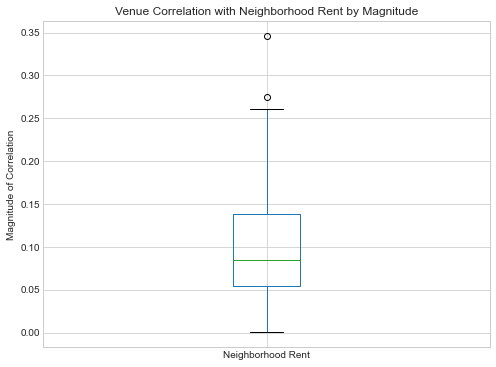

In [209]:
rent_corr.plot(kind='box', figsize=(8,6))
plt.ylabel("Magnitude of Correlation")
plt.title("Venue Correlation with Neighborhood Rent by Magnitude")
plt.show()

In [210]:
# Defining the cutoff as anything below the 75th percentile in magnitude of correlation
cutoff = 0.138766

values = rent_corr[rent_corr < cutoff]
atlanta_model = atlanta_grouped.drop(values.index, axis='columns')

# this model contains only the venues that have a correlation magnitude greater than 0.138766
atlanta_model

,Neighborhood,Neighborhood Rent,Neighborhood Bin,Accessories Store,Art Museum,Athletics & Sports,BBQ Joint,Bank,Bar,Big Box Store,...,Sporting Goods Shop,Sushi Restaurant,Taco Place,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Video Game Store,Wings Joint,Yoga Studio
0,Adair Park,1002,1,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
1,Adamsville,1116,2,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
2,Amhurst,1002,1,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.333333,0.0
3,Ansley Park,2046,4,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.142857,0.0,0.0,0.000000,0.0
4,Ardmore,2046,4,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,Westview Cemetery,1002,1,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
135,Wildwood,1541,3,0.0,0.0,0.000000,0.000000,0.04,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.040000,0.0,0.0,0.000000,0.0
136,Wildwood East,1040,1,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
137,Woodland Hills,1447,3,0.0,0.0,0.000000,0.000000,0.00,0.104167,0.0,...,0.0,0.041667,0.020833,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0


### SVM Classification

In [261]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from sklearn import preprocessing

In [262]:
y = atlanta_model["Neighborhood Bin"]
X = atlanta_model.loc[:,"Accessories Store":]

X = preprocessing.StandardScaler().fit(X).transform(X)
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=4)

In [265]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#### SVM using rbf

In [263]:
rbf = svm.SVC(kernel='rbf')
rbf.fit(X_train, y_train)

SVC()

In [264]:
yhat1 = rbf.predict(X_test)
yhat1[0:5]

array([3, 1, 4, 1, 4])

              precision    recall  f1-score   support

           1       0.21      0.75      0.32         8
           2       1.00      0.08      0.14        13
           3       0.57      0.27      0.36        15
           4       0.78      0.70      0.74        10

    accuracy                           0.39        46
   macro avg       0.64      0.45      0.39        46
weighted avg       0.67      0.39      0.38        46

Confusion matrix, without normalization
[[ 6  0  2  0]
 [12  1  0  0]
 [ 9  0  4  2]
 [ 2  0  1  7]]


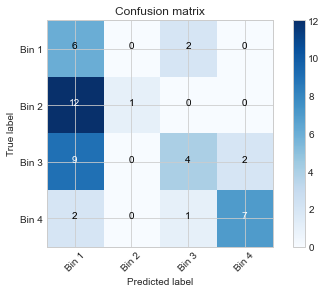

In [266]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat1, labels=[1,2,3,4])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat1))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Bin 1','Bin 2', 'Bin 3', 'Bin 4'],normalize= False,  title='Confusion matrix')

In [267]:
from sklearn.metrics import f1_score
f1_score(y_test, yhat1, average='weighted') 

0.3755370425850975

In [268]:
from sklearn.metrics import jaccard_score
jaccard_score(y_test, yhat, average='weighted')

0.18534449352863674

#### SVM using Linear

In [269]:
lin = svm.SVC(kernel='linear')
lin.fit(X_train, y_train)

SVC(kernel='linear')

In [270]:
yhat2 = lin.predict(X_test)
yhat2 [0:5]

array([3, 1, 4, 1, 4])

              precision    recall  f1-score   support

           1       0.13      0.50      0.21         8
           2       0.75      0.23      0.35        13
           3       0.50      0.20      0.29        15
           4       0.67      0.40      0.50        10

    accuracy                           0.30        46
   macro avg       0.51      0.33      0.34        46
weighted avg       0.54      0.30      0.34        46

Confusion matrix, without normalization
[[ 4  0  3  1]
 [10  3  0  0]
 [10  1  3  1]
 [ 6  0  0  4]]


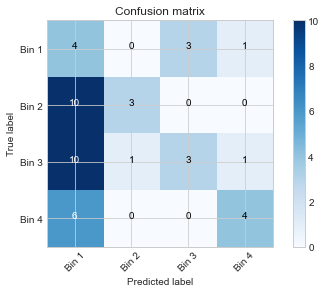

In [271]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat2, labels=[1,2,3,4])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat2))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Bin 1','Bin 2', 'Bin 3', 'Bin 4'],normalize= False,  title='Confusion matrix')

In [272]:
f1_score(y_test, yhat2, average='weighted') 

0.33822087187277655

In [273]:
jaccard_score(y_test, yhat2, average='weighted')

0.20783095847034466

#### SVM using Polynomial

In [274]:
poly = svm.SVC(kernel='poly')
poly.fit(X_train, y_train)

SVC(kernel='poly')

In [275]:
yhat3 = poly.predict(X_test)
yhat3 [0:5]

array([1, 1, 1, 1, 1])

              precision    recall  f1-score   support

           1       0.18      1.00      0.31         8
           2       0.00      0.00      0.00        13
           3       1.00      0.07      0.12        15
           4       1.00      0.10      0.18        10

    accuracy                           0.22        46
   macro avg       0.55      0.29      0.15        46
weighted avg       0.58      0.22      0.13        46

Confusion matrix, without normalization
[[ 8  0  0  0]
 [13  0  0  0]
 [14  0  1  0]
 [ 9  0  0  1]]


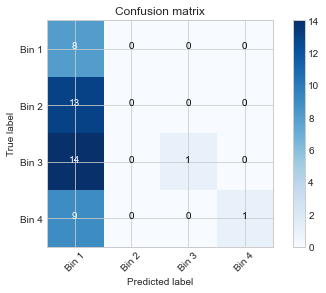

In [284]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat3, labels=[1,2,3,4])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat3))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Bin 1','Bin 2', 'Bin 3', 'Bin 4'],normalize= False,  title='Confusion matrix')

In [285]:
f1_score(y_test, yhat3, average='weighted') 

0.13379826695044086

In [286]:
jaccard_score(y_test, yhat3, average='weighted')

0.07509881422924901

#### SVM using Sigmoid

In [287]:
sig = svm.SVC(kernel='sigmoid')
sig.fit(X_train, y_train)

SVC(kernel='sigmoid')

In [288]:
yhat4 = sig.predict(X_test)
yhat4 [0:5]

array([1, 1, 4, 1, 4])

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.22      1.00      0.36         8
           2       0.00      0.00      0.00        13
           3       1.00      0.13      0.24        15
           4       0.88      0.70      0.78        10

    accuracy                           0.37        46
   macro avg       0.52      0.46      0.34        46
weighted avg       0.55      0.37      0.31        46

Confusion matrix, without normalization
[[ 8  0  0  0]
 [13  0  0  0]
 [12  0  2  1]
 [ 3  0  0  7]]


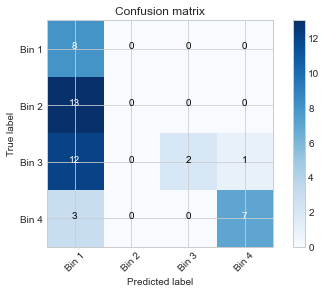

In [289]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat4, labels=[1,2,3,4])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat4))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Bin 1','Bin 2', 'Bin 3', 'Bin 4'],normalize= False,  title='Confusion matrix')

In [290]:
f1_score(y_test, yhat4, average='weighted') 

0.30904957503422975

In [291]:
jaccard_score(y_test, yhat4, average='weighted')

0.2204655248133509

### Classification using Logistic Regression

#### Logistic Regression liblinear

In [292]:
from sklearn.linear_model import LogisticRegression

In [306]:
liblinear = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
yhat5 = liblinear.predict(X_test)
yhat5_prob = liblinear.predict_proba(X_test)

              precision    recall  f1-score   support

           1       0.19      0.62      0.29         8
           2       0.60      0.23      0.33        13
           3       0.60      0.20      0.30        15
           4       0.67      0.60      0.63        10

    accuracy                           0.37        46
   macro avg       0.51      0.41      0.39        46
weighted avg       0.54      0.37      0.38        46

Confusion matrix, without normalization
[[ 5  2  1  0]
 [10  3  0  0]
 [ 9  0  3  3]
 [ 3  0  1  6]]


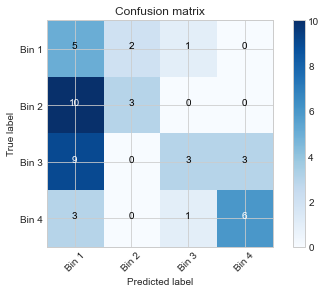

In [307]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat5, labels=[1,2,3,4])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat5))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Bin 1','Bin 2', 'Bin 3', 'Bin 4'],normalize= False,  title='Confusion matrix')

In [308]:
f1_score(y_test, yhat5, average='weighted') 

0.3790181976680833

In [309]:
jaccard_score(y_test, yhat5, average='weighted')

0.24338645157059483

#### Logistic Regression newton-cg

In [310]:
newton = LogisticRegression(C=0.01, solver='newton-cg').fit(X_train,y_train)
yhat6 = newton.predict(X_test)
yhat6_prob = newton.predict_proba(X_test)

              precision    recall  f1-score   support

           1       0.21      1.00      0.35         8
           2       1.00      0.08      0.14        13
           3       1.00      0.13      0.24        15
           4       0.80      0.40      0.53        10

    accuracy                           0.33        46
   macro avg       0.75      0.40      0.31        46
weighted avg       0.82      0.33      0.29        46

Confusion matrix, without normalization
[[ 8  0  0  0]
 [12  1  0  0]
 [12  0  2  1]
 [ 6  0  0  4]]


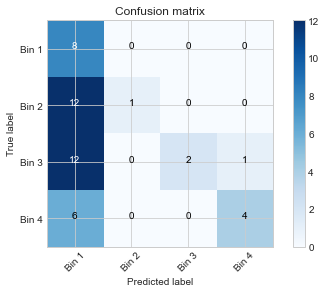

In [311]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat6, labels=[1,2,3,4])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat6))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Bin 1','Bin 2', 'Bin 3', 'Bin 4'],normalize= False,  title='Confusion matrix')

In [312]:
f1_score(y_test, yhat6, average='weighted') 

0.293532535887701

In [313]:
jaccard_score(y_test, yhat6, average='weighted')

0.18088204701477012

#### Logistic Regression lbfgs

In [316]:
lbfgs = LogisticRegression(C=0.01, solver='lbfgs').fit(X_train,y_train)
yhat7 = lbfgs.predict(X_test)
yhat7_prob = lbfgs.predict_proba(X_test)

              precision    recall  f1-score   support

           1       0.21      1.00      0.35         8
           2       1.00      0.08      0.14        13
           3       1.00      0.13      0.24        15
           4       0.80      0.40      0.53        10

    accuracy                           0.33        46
   macro avg       0.75      0.40      0.31        46
weighted avg       0.82      0.33      0.29        46

Confusion matrix, without normalization
[[ 8  0  0  0]
 [12  1  0  0]
 [12  0  2  1]
 [ 6  0  0  4]]


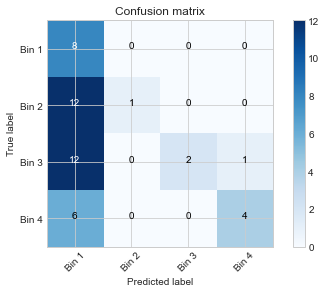

In [317]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat7, labels=[1,2,3,4])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat7))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Bin 1','Bin 2', 'Bin 3', 'Bin 4'],normalize= False,  title='Confusion matrix')

In [318]:
f1_score(y_test, yhat7, average='weighted') 

0.293532535887701

In [320]:
jaccard_score(y_test, yhat7, average='weighted')

0.18088204701477012

#### Logistic Regression sag

In [321]:
sag = LogisticRegression(C=0.01, solver='sag').fit(X_train,y_train)
yhat8 = sag.predict(X_test)
yhat8_prob = sag.predict_proba(X_test)

              precision    recall  f1-score   support

           1       0.21      1.00      0.35         8
           2       1.00      0.08      0.14        13
           3       1.00      0.13      0.24        15
           4       0.80      0.40      0.53        10

    accuracy                           0.33        46
   macro avg       0.75      0.40      0.31        46
weighted avg       0.82      0.33      0.29        46

Confusion matrix, without normalization
[[ 8  0  0  0]
 [12  1  0  0]
 [12  0  2  1]
 [ 6  0  0  4]]


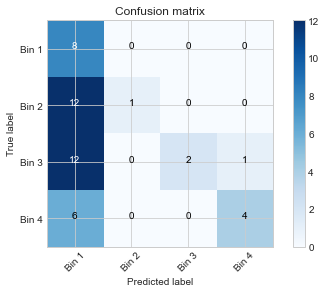

In [322]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat8, labels=[1,2,3,4])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat8))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Bin 1','Bin 2', 'Bin 3', 'Bin 4'],normalize= False,  title='Confusion matrix')

In [323]:
f1_score(y_test, yhat8, average='weighted') 

0.293532535887701

In [324]:
jaccard_score(y_test, yhat8, average='weighted')

0.18088204701477012

#### Logistic Regression saga

In [325]:
saga = LogisticRegression(C=0.01, solver='saga').fit(X_train,y_train)
yhat9 = saga.predict(X_test)
yhat9_prob = saga.predict_proba(X_test)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


              precision    recall  f1-score   support

           1       0.21      1.00      0.35         8
           2       1.00      0.08      0.14        13
           3       1.00      0.13      0.24        15
           4       0.80      0.40      0.53        10

    accuracy                           0.33        46
   macro avg       0.75      0.40      0.31        46
weighted avg       0.82      0.33      0.29        46

Confusion matrix, without normalization
[[ 8  0  0  0]
 [12  1  0  0]
 [12  0  2  1]
 [ 6  0  0  4]]


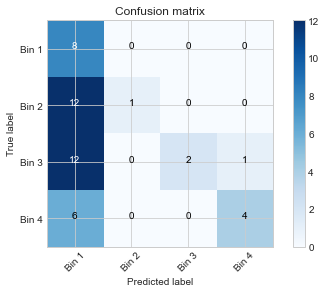

In [326]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat9, labels=[1,2,3,4])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat9))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Bin 1','Bin 2', 'Bin 3', 'Bin 4'],normalize= False,  title='Confusion matrix')

In [327]:
f1_score(y_test, yhat9, average='weighted') 

0.293532535887701

In [328]:
jaccard_score(y_test, yhat9, average='weighted')

0.18088204701477012